In [1]:
############################################################################
##
## Copyright (C) 2022 NVIDIA Corporation.  All rights reserved.
##
## NVIDIA Sample Code
##
## Please refer to the NVIDIA end user license agreement (EULA) associated
## with this source code for terms and conditions that govern your use of
## this software. Any use, reproduction, disclosure, or distribution of
## this software and related documentation outside the terms of the EULA
## is strictly prohibited.
##
############################################################################

In [2]:
import gc
import os

import cudf
import cupy as cp
import iso18245
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.autonotebook import tqdm

sns.set()
pd.set_option('display.max_columns', 500)
ALL_MCCS = sorted([int(mcc.mcc) for mcc in iso18245.get_all_mccs()])

/tmp/ipykernel_640/865221609.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# 1. Evaluating Generated Synthetic Data

In this notebook, we will walk through some ways to evaluate the generated data from our model. As we progress through this notebook, we'll start from very "coarse" grained measures of generated data quality and increase towards more "fine" grained measures. I've attempted to provide some helpful examples to aid in understanding the concept we will apply to the data.

I've provided a sample of ( <u>43 Million</u>) rows of generated data.

There are many ways to compare the real and synthetic data. Here are some of the ways we will look at evaluating our generated synthetic data:

### 1.1 Coarse grained
- What percent of rows did the model duplicate itself? i.e. did the model generate the same row multiple times?
- What percent of rows did the model copy from the real data?

### 1.2 Medium grained
- Use the Kolmogorov-Smirnov test (KS-test) or Chi2 test of a single column in the real and synthetic datasets
- Calculate the Wasserstein distance of a single column in the real and synthetic datasets 
- Overlay the real and generated column distributions

<em>Example:</em> Your interest is comparing credit card purchases in the busy shopping period before Christmas between the real and synthetic data. The data is conditioned on the Christmas shopping period and the calculation is on the amounts spent during that period between the real and synthetic data.

### 1.3 Fine grained
- Compare conditional distributions of 2 or more features in the real dataset to the synthetic dataset.
  
<em>Example 1:</em> Ensure that a city, zip code, and a state are aligned. No fake locations like Beverly Hills, NY.</br>
<em>Example 2:</em> Ensure that the distribution of buy/sell orders are aligned with particular price movements (i.e. after +5% up).

In [3]:
real_data_path = './data/card_transaction_processed.parquet'
synthetic_data_path = './data/synthetic_txns.parquet'

In [4]:
real_df = cudf.read_parquet(real_data_path)
synthetic_df = cudf.read_parquet(synthetic_data_path)


In [5]:
# reordering cols
cols = ['user', 'card', 'year', 'month', 'day', 'hour', 'minute', 'amount',
           'use chip', 'merchant name', 'merchant city', 'merchant state', 'zip',
           'mcc', 'errors', 'is_fraud']
real_df = real_df[cols]
synthetic_df = synthetic_df[cols]


# 2. Coarse grained

What percent of rows did the model duplicate itself? i.e. did the model generate the same row multiple times?

In [6]:
# check for duplicate rows.
len(real_df[cols]), len(real_df[cols].drop_duplicates()),\
len(real_df) - len(real_df[cols].drop_duplicates()), \
100*(len(real_df) - len(real_df[cols].drop_duplicates()))/len(real_df)

(24386900, 24386834, 66, 0.000270637104347006)

In [7]:
# check for duplicate rows.
len(synthetic_df), len(synthetic_df.drop_duplicates()),\
len(synthetic_df) - len(synthetic_df.drop_duplicates()), \
100*(len(synthetic_df) - len(synthetic_df.drop_duplicates()))/len(synthetic_df)

(43005486, 42996425, 9061, 0.021069404959171954)

We see our generated dataset of 43M rows had about 9K duplicated rows, or about 0.02% self duplication rate

In [8]:
total = cudf.concat([real_df[cols], synthetic_df]).to_pandas()
copies = len(total) - len(total.drop_duplicates()) - (len(real_df) - len(real_df.drop_duplicates())) - (len(synthetic_df) - len(synthetic_df.drop_duplicates())) 
del total
copies


45

In [9]:
len(real_df), len(synthetic_df)

(24386900, 43005486)

In [10]:
FACTOR = len(real_df)/len(synthetic_df)
FACTOR

0.5670648623759303

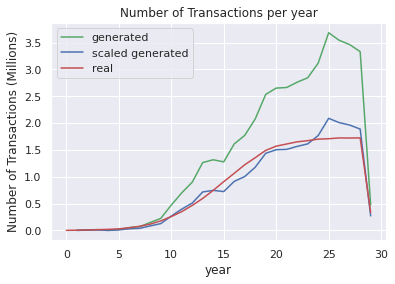

In [11]:
fig, ax = plt.subplots()
(synthetic_df.groupby('year').size().sort_index().to_pandas()/1e6).plot(ax=ax, color='g', label='generated')
(synthetic_df.groupby('year').size().sort_index().to_pandas()*FACTOR/1e6).plot(ax=ax, color='b', label='scaled generated')
(real_df.groupby('year').size().sort_index().to_pandas()/1e6).plot(ax=ax, color='r', label='real')
ax.set_ylabel('Number of Transactions (Millions)')
ax.set_title('Number of Transactions per year')
plt.legend()
# plt.savefig('images/number_of_txns_per_year.png', dpi=600)

# 3. Medium Grained

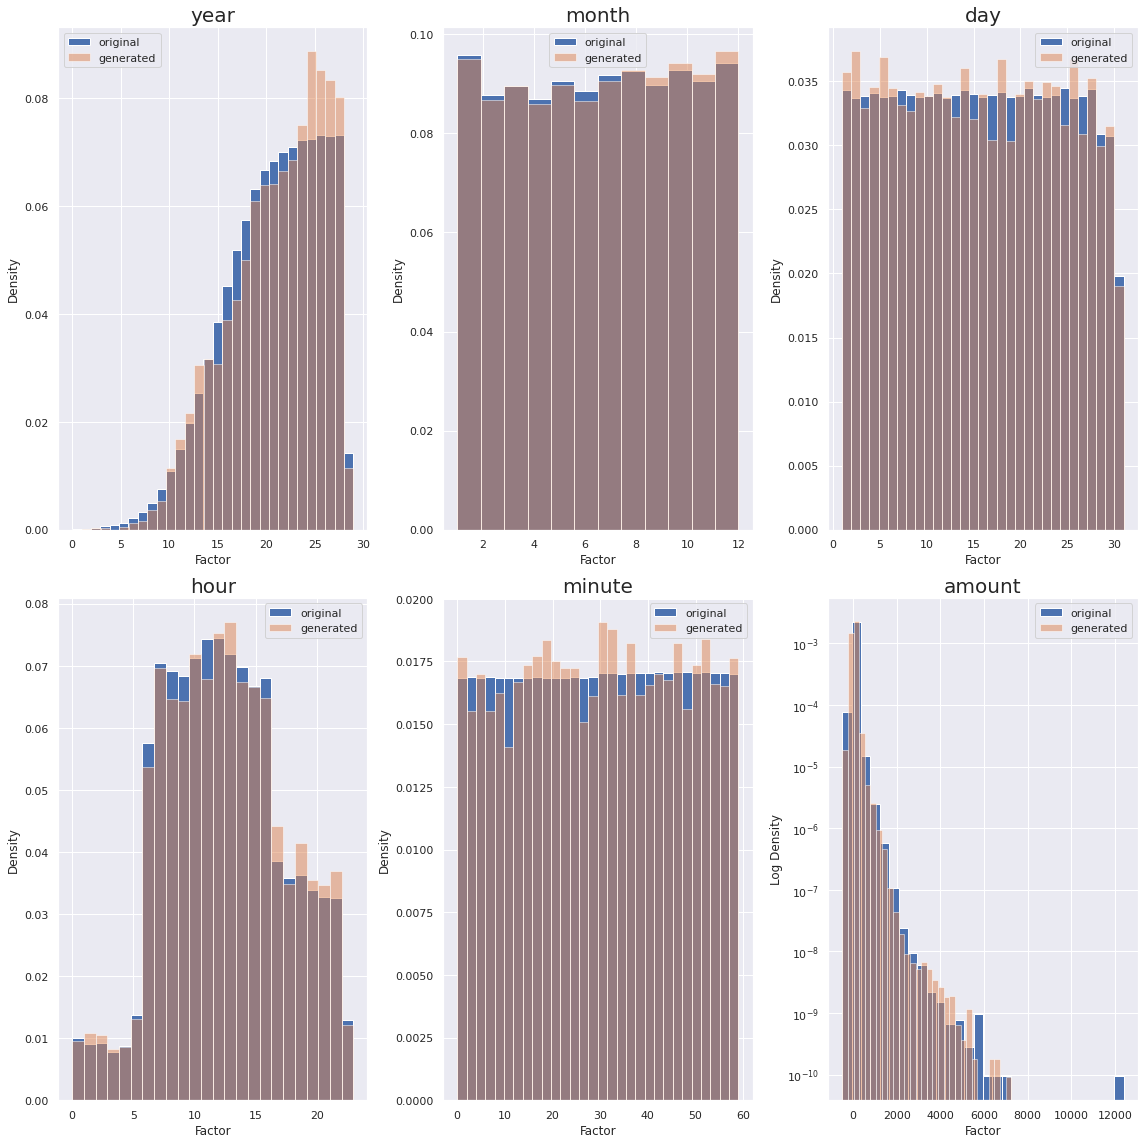

In [12]:
def plot_hist(gdf, gen, col, ax, use_max=False):
    
    # dist = wasserstein_categorical(gdf[col], gen[col])
#     bins = min(gdf[col].nunique(), gen[col].nunique())
#     bins = bins if col != 'year' else 30
    bins_gen = gen[col].nunique()
    bins_orig = gdf[col].nunique()
    
    # normalization scheme, max value or nunique counts.
#     if use_max:
#         dist /= gdf[col].max()
#     else:
#         dist /= bins_orig
    
    logcol = False if col not in ['amount', 'hrs_since_last_txn', 'is_fraud'] else True
    
    if col != 'day':
        if bins_gen > 30:
            bins_gen = 30
        if bins_orig > 30:
            bins_orig = 30
        

    gdf[[col]].to_pandas().hist(ax=ax, density=True, bins=bins_orig, log=logcol, stacked=True, label='original')
    gen[[col]].to_pandas().hist(ax=ax, density=True, bins=bins_gen, log=logcol, alpha=0.5, label='generated')
    ax.set_xlabel(f'Factor')
    ax.set_ylabel(f'Density' if not logcol else 'Log Density')
    ax.set_title(f'{col}',  fontsize=20)
    ax.legend(['original', 'generated'])
    plt.tight_layout()
    # plt.savefig(f'{save_path}/{col}_distribution.png', dpi=1200)

nrows=2
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))
for i, col in enumerate(['year',  'month', 'day', 'hour', 'minute', 'amount']):
    plot_hist(real_df, synthetic_df, col, ax[i//ncols][i%(1+nrows)], use_max=True)

# 4. Fine Grained

In [13]:
N=5
# find the most active merchants
topN_real = real_df.groupby(['merchant name']).size().sort_values(ascending=False).iloc[:N]  #.to_pandas().plot(kind='hist',bins=30, log=True)
topN_real

merchant name
59935    1130230
27092    1129061
61195    1028485
39021     720615
43293     687779
dtype: int32

In [14]:
topN_synth = synthetic_df.groupby(['merchant name']).size().sort_values(ascending=False).iloc[:N]  #.to_pandas().plot(kind='hist',bins=30, log=True)  # to plot distribution
topN_synth

merchant name
59935    1898286
61195    1834378
27092    1761804
43293    1208706
14528    1136260
dtype: int32

In [15]:
for merch, mcc in real_df.loc[real_df['merchant name'].isin(topN_real.index), ['merchant name', 'mcc']].to_pandas().value_counts().index:
    print('merchant name:', merch, '\nMCC:', iso18245.get_mcc(str(ALL_MCCS[mcc])), '\n')

merchant name: 59935 
MCC: MCC(mcc='5499', range=MCCRange(start='5000', end='5599', description='Retail outlets', reserved=False), iso_description='Miscellaneous food shops — convenience and speciality retail outlets', usda_description='Misc. Food Stores – Convenience Stores and Specialty Markets', stripe_description='Miscellaneous Food Stores - Convenience Stores and Specialty Markets', stripe_code='miscellaneous_food_stores', visa_description='Miscellaneous Food Stores – Convenience Stores and Specialty Markets', visa_req_clearing_name='', alipay_description='Miscellaneous food shops - convenience and speciality retail outlets') 

merchant name: 27092 
MCC: MCC(mcc='4829', range=MCCRange(start='4800', end='4999', description='Utilities', reserved=False), iso_description='Wire transfers and money orders', usda_description='Money Orders – Wire Transfer', stripe_description='Wires, Money Orders', stripe_code='wires_money_orders', visa_description='Money Transfer', visa_req_clearing_name

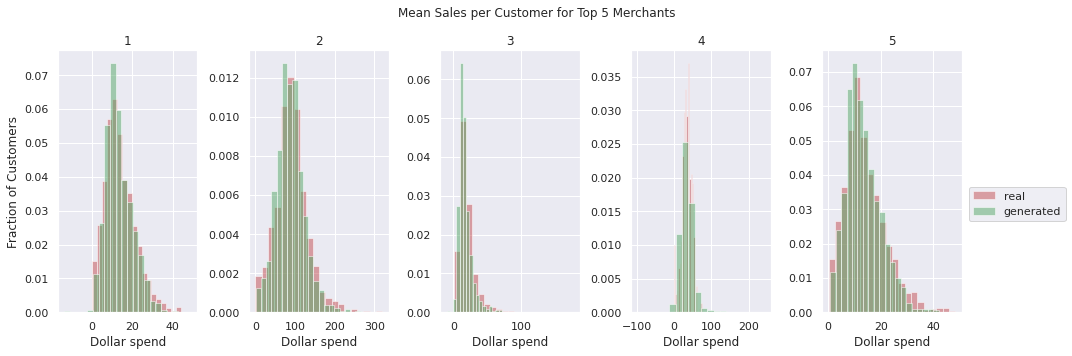

In [16]:
# INCLUDE
sales_per_customer_merch_real = real_df[['user', 'merchant name', 'amount']].groupby(['merchant name', 'user']).amount.mean().reset_index()
sales_per_customer_merch_synth = synthetic_df[['user', 'merchant name', 'amount']].groupby(['merchant name', 'user']).amount.mean().reset_index()

fig, ax = plt.subplots(ncols=N, figsize=(15,5))

for n in range(N):
    sales_per_customer_merch_real.loc[sales_per_customer_merch_real['merchant name'].isin(topN_real.index.values[n])].to_pandas().reset_index()\
                                 .hist('amount', bins=20, ax=ax[n], color='r', density=True, label='real', alpha=0.5)
    sales_per_customer_merch_synth.loc[sales_per_customer_merch_synth['merchant name'].isin(topN_real.index.values[n])].to_pandas().reset_index()\
                                 .hist('amount', bins=20, ax=ax[n], color='g', density=True, label='generated', alpha=0.5)
    ax[n].set_title(f'{n+1}')
    if not n :
        ax[n].set_ylabel('Fraction of Customers')
    ax[n].set_xlabel('Dollar spend')
plt.suptitle(f'Mean Sales per Customer for Top {N} Merchants')
plt.legend(bbox_to_anchor=(1.01, 0.5))    
plt.tight_layout()

fpath = f'images/mean_sales_per_customer_top_{N}_merchants.png'
# plt.savefig(fpath, dpi=600)

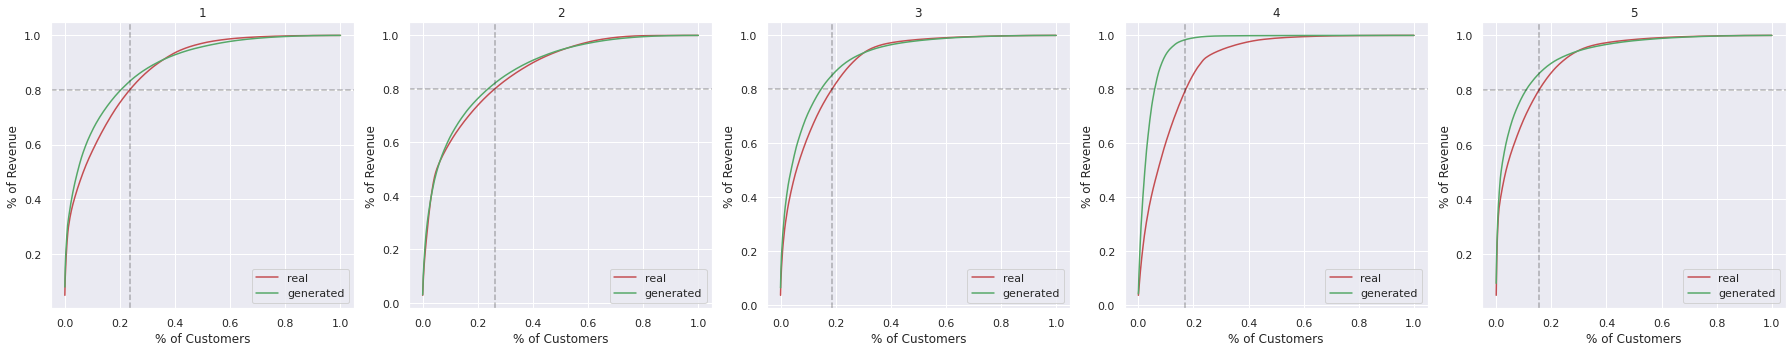

In [17]:
# INCLUDE
fig, ax = plt.subplots(ncols=N, figsize=(25,5))

for n in range(N):
    
    real = (real_df.loc[real_df['merchant name'].isin(topN_real.index.values[n])].groupby('user').amount.sum().sort_values(ascending=False)/real_df.loc[real_df['merchant name'].isin(topN_real.index.values[n])].amount.sum()).cumsum().to_pandas().reset_index(drop=True).to_frame()
    real['customer_pct'] = np.linspace(0, 1, len(real))
    real.plot('customer_pct', 'amount', ax=ax[n], color='r', label='real')
    
    synth = (synthetic_df.loc[synthetic_df['merchant name'].isin(topN_real.index.values[n])].groupby('user').amount.sum().sort_values(ascending=False)/synthetic_df.loc[synthetic_df['merchant name'].isin(topN_real.index.values[n])].amount.sum()).cumsum().to_pandas().reset_index(drop=True).to_frame()
    synth['customer_pct'] = np.linspace(0, 1, len(synth))
    synth.plot('customer_pct', 'amount', ax=ax[n], color='g', label='generated')

    ax[n].axhline(0.8, ls='--', color='k', alpha=0.3)
    ax[n].axvline(real.loc[real.amount < 0.8].customer_pct.max(), ls='--', color='k', alpha=0.3)
    
    ax[n].set_title(f'{n+1}')
    ax[n].set_xlabel('% of Customers')
    ax[n].set_ylabel('% of Revenue')

# plt.legend(bbox_to_anchor=(1.01, 0.5)) 
plt.tight_layout()

fpath = f'images/revenue_to_customers_80_20.png'
# plt.savefig(fpath, dpi=600)